# Gesture Recognition


### This Case Study is made by L Rohan & Rohit Raju Vatsavaya

- The best model is not saved as h5 file but as keras file, h5 is depreciated in Checkpoints.

In [ ]:
import numpy as np
import datetime
import os
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [5]:
import os
os.environ['PYTHONHASHSEED']="30"
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
tf.random.set_seed(30)
from keras import backend as K

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [6]:
# train and validatiaon data creator with ablation
# when ablation is 10, then 10 folders for each label will be selected.
def get_data(path, ablation=None):
    train_doc = np.random.permutation(open(path+'train.csv').readlines())
    val_doc = np.random.permutation(open(path+'val.csv').readlines())
    counts = np.zeros(5) # count for loading folders for 5 classes
    train_data = []
    val_data = []
    # when ablation is None pass full training and val data
    if ablation is not None:
        # iterating train doc
        for doc in train_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < ablation:
                train_data.append(doc)
                counts[lable] += 1 
        counts = np.zeros(5)
        # iterating val doc
        for doc in val_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < ablation:
                val_data.append(doc)
                counts[lable] += 1
    else:
        train_data, val_data = train_doc, val_doc
    return train_data, val_data

In [7]:
train_doc, val_doc = get_data('Project_data/', ablation=None)
batch_size = 32 # experiment with the batch size
enable_augmentation = False # augmentation of Data
# sequence ids
# selecting alternate frames from 7 to 26.
seq_idx = range(7,26,2)
# image dimensions
dim_x, dim_y = 120, 120

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [11]:
def generator(source_path, folder_list, batch_size, is_train=False, augmention=False, debug=False):
    # print('\nSource path = ', source_path, '; batch size =', batch_size)
    img_idx = seq_idx  # create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y, z = dim_x, dim_y
    while True:
        # Doubling the data for augmentation
        if is_train and augmention:
            t = np.concatenate((np.random.permutation(folder_list), np.random.permutation(folder_list)))
        else:
            t = np.random.permutation(folder_list)
            
        # Determine the number of batches
        num_batches = len(t) // batch_size + (1 if len(t) % batch_size != 0 else 0)
            
        for batch in range(num_batches):  # Iterate over the number of batches
            batch_data = np.zeros((batch_size, x, y, z, 3))  # Placeholder for batch data
            batch_labels = np.zeros((batch_size, 5))  # Placeholder for batch labels
            
            for folder in range(batch_size):  # Iterate over batch size
                if debug:
                    plt.figure(figsize=(20, 5))
                
                # Handle remaining data points
                folder_idx = folder + (batch * batch_size)
                if folder_idx >= len(t):
                    break
                
                folder_str = t[folder_idx]
                imgs = os.listdir(source_path + '/' + folder_str.split(';')[0])  # Read all images in the folder
                
                # Randomly enable augmentation and select augmentation type
                aug_type = None
                if is_train and augmention and rn.randint(0, 1) == 1:
                    aug_type = rn.randint(0, 4)  # Randomly select augmentation type
                
                for idx, item in enumerate(img_idx):  # Iterate over the frames/images of a folder
                    # Read the image using Pillow
                    image_path = f"{source_path}/{folder_str.strip().split(';')[0]}/{imgs[item]}"
                    image_pil = Image.open(image_path).convert('RGB')  # Ensure RGB format
                    image = np.array(image_pil).astype(np.float32)

                    # Plot original images for debugging purposes
                    if debug:
                        plt.subplot(2, x, idx + 1)
                        plt.imshow(image.astype('uint8'))

                    # Crop the images to make them square
                    if image.shape[1] > image.shape[0]:  # Landscape orientation
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px // 2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:  # Portrait orientation
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px // 2
                        crop_end = crop_start + image.shape[1]
                        image = image[crop_start:crop_end, :]

                    # Resize the image
                    resized_im = Image.fromarray(image.astype('uint8')).resize((y, z), Image.Resampling.LANCZOS)
                    resized_im = np.array(resized_im)  # Convert back to NumPy array

                    # Apply augmentations if enabled
                    if aug_type is not None:
                        if aug_type == 0:  # Edge Enhancement
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.EDGE_ENHANCE))
                        elif aug_type == 1:  # Add Gaussian Blur
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.GaussianBlur(1)))
                        elif aug_type == 2:  # Enhance Image Details
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.DETAIL))
                        elif aug_type == 3:  # Sharpen Image
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.SHARPEN))
                        elif aug_type == 4:  # Brightness Enhancement
                            resized_im = np.array(ImageEnhance.Brightness(Image.fromarray(resized_im, 'RGB')).enhance(1.5))

                    # Plot resized images for debugging purposes
                    if debug:
                        plt.subplot(2, x, idx + x + 1)
                        plt.imshow(resized_im)

                    # Normalize and feed into the batch data
                    batch_data[folder, idx, :, :, 0] = resized_im[:, :, 0] / 255.0
                    batch_data[folder, idx, :, :, 1] = resized_im[:, :, 1] / 255.0
                    batch_data[folder, idx, :, :, 2] = resized_im[:, :, 2] / 255.0

                # Create one-hot labels
                batch_labels[folder, int(folder_str.strip().split(';')[2])] = 1
            
            # Yield the batch data and labels
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [12]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train' #'/notebooks/storage/Final_data/Collated_training/train'
val_path =  'Project_data/val' #'/notebooks/storage/Final_data/Collated_training/val'

#multiply number train seq by 2 when using augmentation
multiplier = 1
if enable_augmentation:
    multiplier = 2
num_train_sequences = len(train_doc)*multiplier
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


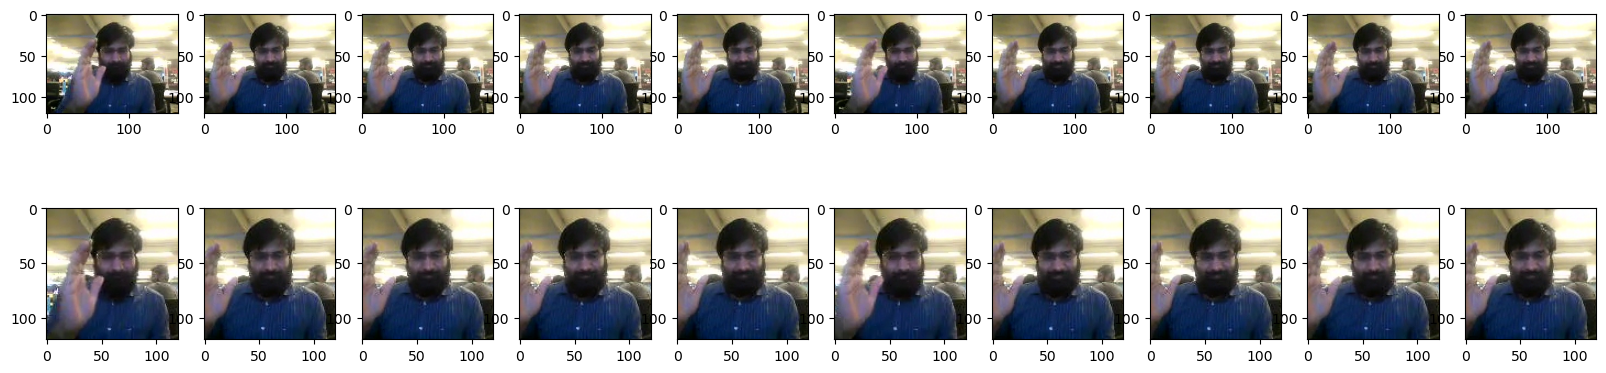

In [13]:
# testing generative 
test_gen = generator(train_path, train_doc, 1, is_train = True, augmention = True, debug = True)
d = next(test_gen)[0]

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [15]:
from keras.models import Sequential, Model
from keras.layers import (
    Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, 
    Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, 
    ConvLSTM2D, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
)
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

# Input shape for the first layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)


### Experiment - 1 & 2
**Conv3D**

In [16]:
model = Sequential()
model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

2024-12-09 13:00:21.919517: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-12-09 13:00:21.919560: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-09 13:00:21.919576: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-09 13:00:21.919786: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-09 13:00:21.919805: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Experiment - 3
**Conv3D**

In [18]:
model = Sequential()

# Layer 1
model.add(Conv3D(32, kernel_size=3, activation='relu', padding='same', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Layer 2
model.add(Conv3D(128, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Layer 3
model.add(Conv3D(256, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Layer 4
model.add(Conv3D(512, kernel_size=3, activation='relu', padding='same'))
model.add(Conv3D(512, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))


### Experiment - 4
**Conv3D**

In [19]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

### Experiment - 5 & 6
**Conv3D**

In [20]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

### Experiment - 7 & 8
**Conv3D**

In [21]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dropout(0.5))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dropout(0.5))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dropout(0.5))

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

### Experiment - 9
**Conv3D**

In [22]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

### Experiment - 10
**Conv3D**

In [24]:
# loss: 0.1388 - categorical_accuracy: 0.9539 - val_loss: 0.1661 - val_categorical_accuracy: 0.9297
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GlobalAveragePooling3D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

### Experiment - 11
**TimeDistributed Conv2D + GRU**

In [25]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())

model.add(TimeDistributed(
    Conv2D(64, (3,3), activation='relu'))
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())

model.add(GRU(128))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

### Experiment - 12
**TimeDistributed Conv2D + GRU**

In [26]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(TimeDistributed(
    Conv2D(64, (3,3), activation='relu'))
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GRU(128))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

### Experiment - 13
**TimeDistributed Conv2D + Dense**

In [27]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())

model.add(TimeDistributed(
    Conv2D(64, (3,3), activation='relu'))
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())

model.add(TimeDistributed(
    Conv2D(128, (3,3), activation='relu'))
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())

model.add(GlobalAveragePooling3D())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

### Experiment - 14
**TimeDistributed + ConvLSTM2D**

In [28]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

# Final Model

In [29]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [31]:
optimiser = optimizers.Adam(learning_rate=0.01)  # Correct argument name
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_21             │ (None, 10, 118, 118,   │           224 │
│ (TimeDistributed)               │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 10, 118, 118,   │            32 │
│ (BatchNormalization)            │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_22             │ (None, 10, 116, 116,   │         1,168 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 10, 116, 116,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 114, 114, 8)    │         6,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 114, 114, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_23             │ (None, 114, 114, 64)   │           576 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 114, 114, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,781 (53.83 KB)

 Trainable params: 13,589 (53.08 KB)

 Non-trainable params: 192 (768.00 B)

None


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [32]:
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
curr_dt_time = datetime.datetime.now()
model_name = 'model_init_exp_16' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

# Filepath for saving model checkpoints
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# ModelCheckpoint callback with save_freq instead of period
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# Set up ReduceLROnPlateau callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)


callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [37]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [40]:
history = model.fit(train_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=num_epochs, 
                    verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, 
                    class_weight=None, 
                    initial_epoch=0)

Epoch 1/50


2024-12-09 13:12:56.940401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3183 - loss: 1.4636
Epoch 1: saving model to model_init_exp_16_2024-12-0913_09_20.232835/model-00001-1.37190-0.35863-1.42837-0.14062.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - categorical_accuracy: 0.3201 - loss: 1.4594 - val_categorical_accuracy: 0.1406 - val_loss: 1.4284 - learning_rate: 0.0100
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4622 - loss: 1.1876
Epoch 2: saving model to model_init_exp_16_2024-12-0913_09_20.232835/model-00002-1.25808-0.44345-1.21176-0.18750.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - categorical_accuracy: 0.4613 - loss: 1.1908 - val_categorical_accuracy: 0.1875 - val_loss: 1.2118 - learning_rate: 0.0100
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5168 - loss: 1.0985
Epoch 3: saving model to model_init_exp_16_2024-12-0913_09_20.232835/model-00003-1.11668-0.49107-1.24031-0.19531.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - ca

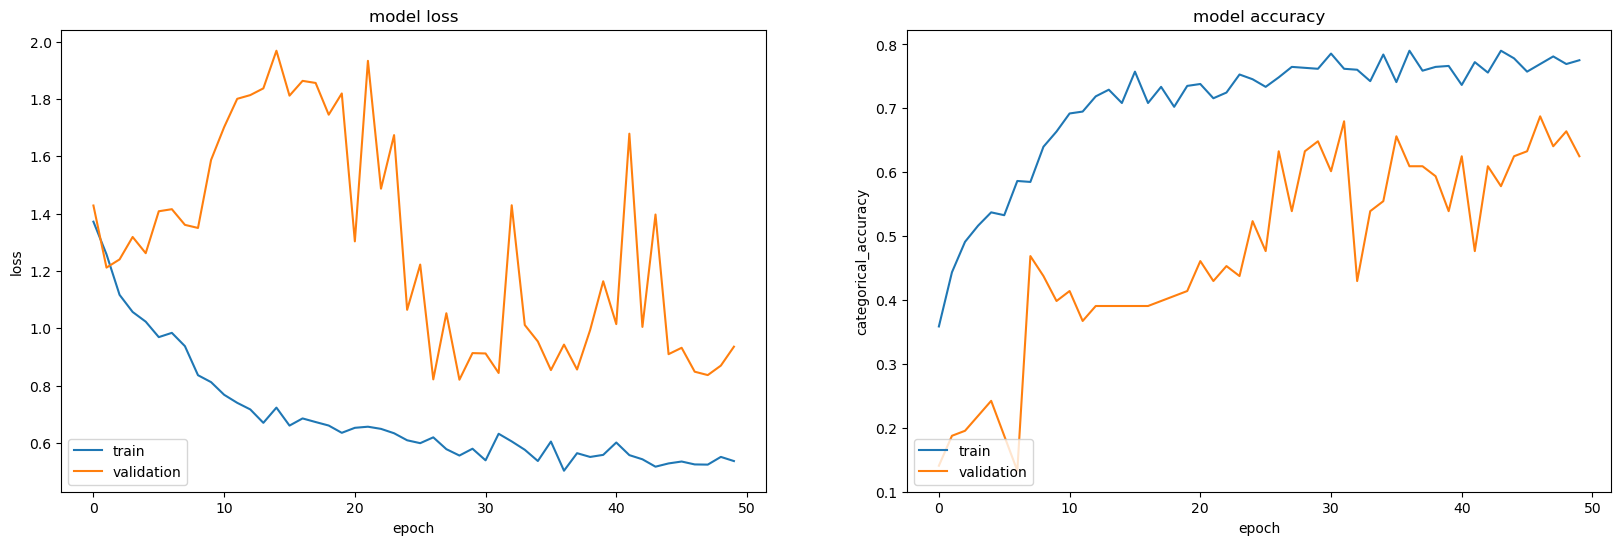

In [41]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')